<a href="https://colab.research.google.com/github/qlqqqk/Aiffel_prac/blob/main/GD/%5BG_4%5DNewsCategoryClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

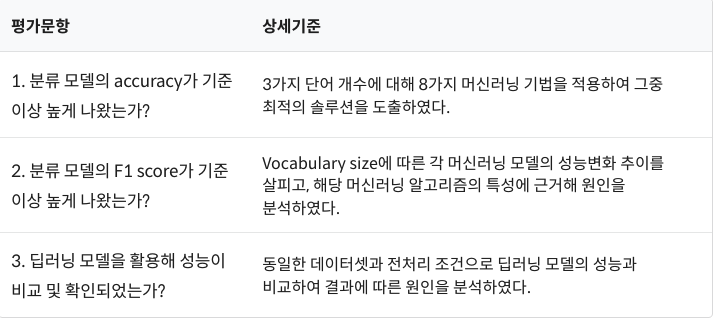

In [152]:
from tensorflow.keras.datasets import reuters
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import operator
import sklearn

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB,ComplementNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,VotingClassifier
from sklearn.svm import LinearSVC
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,f1_score #정확도 계산

print(tensorflow.__version__)
print(matplotlib.__version__)
print(sns.__version__)
print(np.__version__)
print(pd.__version__)
print(sklearn.__version__)

2.8.2
3.2.2
0.11.2
1.21.6
1.3.5
1.0.2


## 데이터 로드

In [156]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)
(x_train2, y_train2), (x_test2, y_test2) = reuters.load_data(num_words=8000, test_split=0.2)
(x_train3, y_train3), (x_test3, y_test3) = reuters.load_data(num_words=5000, test_split=0.2)

In [157]:
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))
print('훈련2 샘플의 수: {}'.format(len(x_train2)))
print('테스트2 샘플의 수: {}'.format(len(x_test2)))
print('훈련3 샘플의 수: {}'.format(len(x_train3)))
print('테스트3 샘플의 수: {}'.format(len(x_test3)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246
훈련2 샘플의 수: 8982
테스트2 샘플의 수: 2246
훈련3 샘플의 수: 8982
테스트3 샘플의 수: 2246


In [158]:
print(f'클래스 : {len(np.unique(y_train))}')

클래스 : 46


뉴스의 최대 길이 :2376
뉴스의 평균 길이 :145.5398574927633


<function matplotlib.pyplot.show>

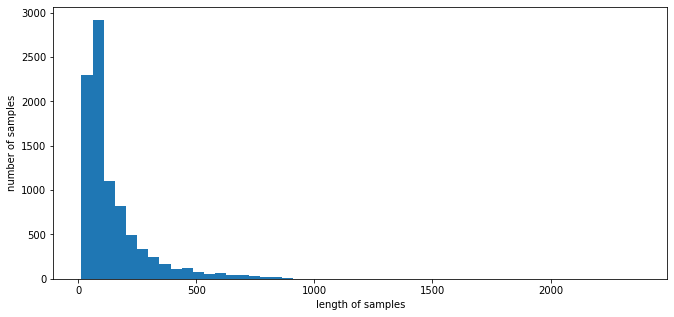

In [159]:
print('뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show 

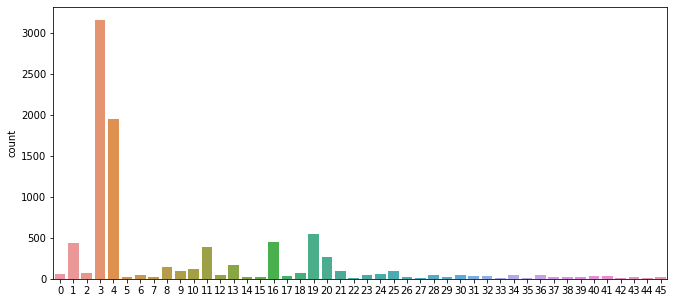

In [160]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

In [161]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 클래스 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


In [162]:
word_index = reuters.get_word_index(path="reuters_word_index.json")
print('=3')

=3


In [163]:
sorted(word_index.items(),key=operator.itemgetter(1))

[('the', 1),
 ('of', 2),
 ('to', 3),
 ('in', 4),
 ('said', 5),
 ('and', 6),
 ('a', 7),
 ('mln', 8),
 ('3', 9),
 ('for', 10),
 ('vs', 11),
 ('dlrs', 12),
 ('it', 13),
 ('reuter', 14),
 ('000', 15),
 ('1', 16),
 ('pct', 17),
 ('on', 18),
 ('from', 19),
 ('is', 20),
 ('that', 21),
 ('its', 22),
 ('cts', 23),
 ('by', 24),
 ('at', 25),
 ('year', 26),
 ('be', 27),
 ('with', 28),
 ('2', 29),
 ('will', 30),
 ('was', 31),
 ('billion', 32),
 ('he', 33),
 ('u', 34),
 ('s', 35),
 ('net', 36),
 ('has', 37),
 ('would', 38),
 ('an', 39),
 ('as', 40),
 ('5', 41),
 ('not', 42),
 ('loss', 43),
 ('4', 44),
 ('1986', 45),
 ('company', 46),
 ('which', 47),
 ('but', 48),
 ('this', 49),
 ('shr', 50),
 ('last', 51),
 ('are', 52),
 ('lt', 53),
 ('have', 54),
 ('or', 55),
 ('6', 56),
 ('bank', 57),
 ('7', 58),
 ('were', 59),
 ('8', 60),
 ('had', 61),
 ('oil', 62),
 ('trade', 63),
 ('share', 64),
 ('one', 65),
 ('about', 66),
 ('0', 67),
 ('inc', 68),
 ('9', 69),
 ('new', 70),
 ('profit', 71),
 ('also', 72),
 ('

In [164]:
index_to_word = { index+3 : word for word, index in word_index.items() }

# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

In [165]:
print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


In [166]:
def train_decode(x_train=x_train):
  decoded = []
  for i in range(len(x_train)):
      t = ' '.join([index_to_word[index] for index in x_train[i]])
      decoded.append(t)

  x_train = decoded
  print(len(x_train))
  return x_train
x_train = train_decode()
x_train2 = train_decode(x_train2)
x_train3 = train_decode(x_train3)

8982
8982
8982


In [167]:
def test_decode(x_test=x_test):
  decoded = []
  for i in range(len(x_test)):
      t = ' '.join([index_to_word[index] for index in x_test[i]])
      decoded.append(t)

  x_test = decoded
  print(len(x_test))
  return x_test
x_test = test_decode()
x_test2 = test_decode(x_test2)
x_test3 = test_decode(x_test3)

2246
2246
2246


In [170]:
dtmvector = CountVectorizer()
tfidf_transformer = TfidfTransformer()
def tfidf(x_train=x_train,x_test=x_test):
  x_train_dtm = dtmvector.fit_transform(x_train)
  x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환

  print(x_train_dtm.shape,x_test_dtm.shape)
  tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
  tfidfv_test = tfidf_transformer.transform(x_test_dtm) 
  print(tfidfv.shape,tfidfv_test.shape)
  print('=================================')
  return tfidfv,tfidfv_test
tfidfv,tfidfv_test = tfidf()
tfidfv2,tfidfv_test2 = tfidf(x_train2,x_test2)
tfidfv3,tfidfv_test3 = tfidf(x_train3,x_test3)

(8982, 26506) (2246, 26506)
(8982, 26506) (2246, 26506)
(8982, 7772) (2246, 7772)
(8982, 7772) (2246, 7772)
(8982, 4867) (2246, 4867)
(8982, 4867) (2246, 4867)


## 모델학습 머신러닝

In [188]:
acc = []
f1 = []
name= []
def modelTrain(model,x_train=x_train,y_train=y_train,tfidfv_test=tfidfv_test,y_test=y_test):
  model.fit(x_train,y_train)
  predicted = model.predict(tfidfv_test) #테스트 데이터에 대한 예측
  f1_s = f1_score(y_test,predicted,average='weighted').mean()
  print("정확도:{0:.4f} F1:{0:.4f}".format(accuracy_score(y_test, predicted),f1_s)) #예측값과 실제값 비교
  print('=================================')
  return accuracy_score(y_test, predicted),f1_s

In [189]:
MNB = MultinomialNB()

acc_1,f1_1 = modelTrain(MNB,tfidfv)
acc_2,f1_2 = modelTrain(MNB,tfidfv2,y_train2,tfidfv_test2,y_test2)
acc_3,f1_3 = modelTrain(MNB,tfidfv3,y_train3,tfidfv_test3,y_test3)
name.extend(['MNB1','MNB2','MNB3'])
acc.extend([acc_1,acc_2,acc_3])
f1.extend([f1_1,f1_2,f1_3])

정확도:0.5997 F1:0.5997
정확도:0.6625 F1:0.6625
정확도:0.6732 F1:0.6732


In [100]:
MNB.predict(tfidfv_test3[3])

array([4])

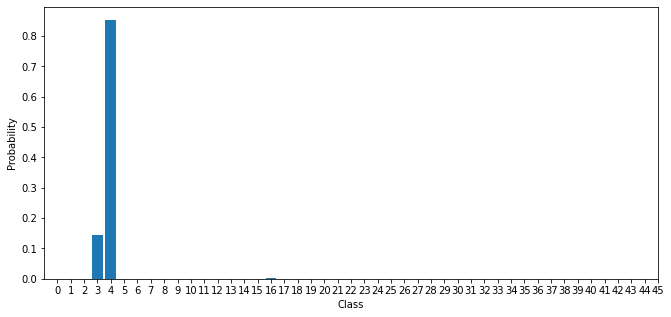

In [101]:
probability_3 = MNB.predict_proba(tfidfv_test3[3])[0]

plt.rcParams["figure.figsize"] = (11,5)
plt.bar(MNB.classes_, probability_3)
plt.xlim(-1, 21)
plt.xticks(MNB.classes_)
plt.xlabel("Class")
plt.ylabel("Probability")
plt.show()

In [104]:
print(classification_report(y_test3, MNB.predict(tfidfv_test3), zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.77      0.53      0.63       105
           2       0.00      0.00      0.00        20
           3       0.77      0.91      0.84       813
           4       0.47      0.96      0.63       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.04      0.08        25
          10       0.00      0.00      0.00        30
          11       0.69      0.40      0.50        83
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.75      0.41      0.53        99
          17       0.00    

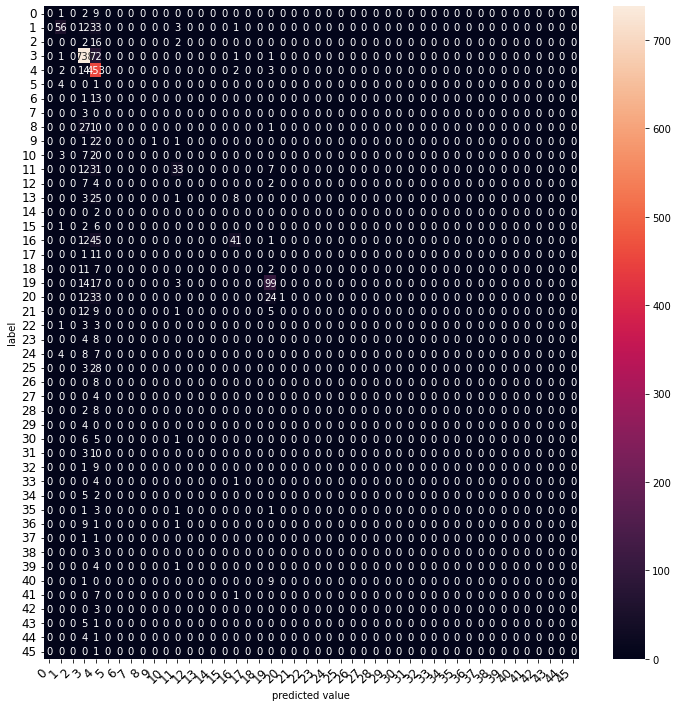

In [106]:
def graph_confusion_matrix(model, x_test, y_test):#, classes_name):
  df_cm = pd.DataFrame(confusion_matrix(y_test, model.predict(x_test)))#, index=classes_name, columns=classes_name)
  fig = plt.figure(figsize=(12,12))
  heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
  plt.ylabel('label')
  plt.xlabel('predicted value')

graph_confusion_matrix(MNB, tfidfv_test3, y_test3)

In [192]:
CNB = ComplementNB()
acc_1,f1_1 = modelTrain(CNB,tfidfv)
acc_2,f1_2 = modelTrain(CNB,tfidfv2,y_train2,tfidfv_test2,y_test2)
acc_3,f1_3 = modelTrain(CNB,tfidfv3,y_train3,tfidfv_test3,y_test3)

name.extend(['CNB1','CNB2','CNB3'])
acc.extend([acc_1,acc_2,acc_3])
f1.extend([f1_1,f1_2,f1_3])

정확도:0.7649 F1:0.7649
정확도:0.7707 F1:0.7707
정확도:0.7707 F1:0.7707


In [193]:
LR = LogisticRegression(C=10000,penalty='l2')
acc_1,f1_1 = modelTrain(LR,tfidfv)
acc_2,f1_2 = modelTrain(LR,tfidfv2,y_train2,tfidfv_test2,y_test2)
acc_3,f1_3 = modelTrain(LR,tfidfv3,y_train3,tfidfv_test3,y_test3)

name.extend(['LR1','LR2','LR3'])
acc.extend([acc_1,acc_2,acc_3])
f1.extend([f1_1,f1_2,f1_3])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


정확도:0.8134 F1:0.8134


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


정확도:0.8099 F1:0.8099
정확도:0.8059 F1:0.8059


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [194]:
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
acc_1,f1_1 = modelTrain(lsvc,tfidfv)
acc_2,f1_2 = modelTrain(lsvc,tfidfv2,y_train2,tfidfv_test2,y_test2)
acc_3,f1_3 = modelTrain(lsvc,tfidfv3,y_train3,tfidfv_test3,y_test3)

name.extend(['lsvc1','lsvc2','lsvc3'])
acc.extend([acc_1,acc_2,acc_3])
f1.extend([f1_1,f1_2,f1_3])

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


정확도:0.7863 F1:0.7863


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


정확도:0.7729 F1:0.7729
정확도:0.7703 F1:0.7703


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [195]:
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
acc_1,f1_1 = modelTrain(tree,tfidfv)
acc_2,f1_2 = modelTrain(tree,tfidfv2,y_train2,tfidfv_test2,y_test2)
acc_3,f1_3 = modelTrain(tree,tfidfv3,y_train3,tfidfv_test3,y_test3)

name.extend(['tree1','tree2','tree3'])
acc.extend([acc_1,acc_2,acc_3])
f1.extend([f1_1,f1_2,f1_3])

정확도:0.6211 F1:0.6211
정확도:0.6207 F1:0.6207
정확도:0.6180 F1:0.6180


In [196]:
RF = RandomForestClassifier(n_estimators=5,random_state=0)
acc_1,f1_1 = modelTrain(RF,tfidfv)
acc_2,f1_2 = modelTrain(RF,tfidfv2,y_train2,tfidfv_test2,y_test2)
acc_3,f1_3 = modelTrain(RF,tfidfv3,y_train3,tfidfv_test3,y_test3)

name.extend(['RF1','RF2','RF3'])
acc.extend([acc_1,acc_2,acc_3])
f1.extend([f1_1,f1_2,f1_3])

정확도:0.6545 F1:0.6545
정확도:0.6670 F1:0.6670
정확도:0.7012 F1:0.7012


In [197]:
grbt = GradientBoostingClassifier(validation_fraction=0.2,n_iter_no_change=5,tol=0.01,random_state=0) # verbose=3
acc_1,f1_1 = modelTrain(grbt,tfidfv)
acc_2,f1_2 = modelTrain(grbt,tfidfv2,y_train2,tfidfv_test2,y_test2)
acc_3,f1_3 = modelTrain(grbt,tfidfv3,y_train3,tfidfv_test3,y_test3)

name.extend(['grbt1','grbt2','grbt3'])
acc.extend([acc_1,acc_2,acc_3])
f1.extend([f1_1,f1_2,f1_3])

정확도:0.7088 F1:0.7088
정확도:0.7240 F1:0.7240
정확도:0.7306 F1:0.7306


In [198]:
voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(validation_fraction=0.2,n_iter_no_change=5,tol=0.01,random_state=0))
], voting='soft', n_jobs=-1)
acc_1,f1_1 = modelTrain(voting_classifier,tfidfv)
acc_2,f1_2 = modelTrain(voting_classifier,tfidfv2,y_train2,tfidfv_test2,y_test2)
acc_3,f1_3 = modelTrain(voting_classifier,tfidfv3,y_train3,tfidfv_test3,y_test3)

name.extend(['vote1','vote2','vote3'])
acc.extend([acc_1,acc_2,acc_3])
f1.extend([f1_1,f1_2,f1_3])

정확도:0.8175 F1:0.8175
정확도:0.8161 F1:0.8161
정확도:0.8157 F1:0.8157


In [199]:
XGB = xgb.XGBClassifier()
acc_1,f1_1 = modelTrain(XGB,tfidfv)
acc_2,f1_2 = modelTrain(XGB,tfidfv2,y_train2,tfidfv_test2,y_test2)
acc_3,f1_3 = modelTrain(XGB,tfidfv3,y_train3,tfidfv_test3,y_test3)

name.extend(['XGB1','XGB2','XGB3'])
acc.extend([acc_1,acc_2,acc_3])
f1.extend([f1_1,f1_2,f1_3])

정확도:0.8161 F1:0.8161
정확도:0.8170 F1:0.8170
정확도:0.8210 F1:0.8210


In [207]:
plot_data = pd.DataFrame({'model':name,'Accuracy':acc,'F1_score':f1})
plot_data

,model,Accuracy,F1_score
0,MNB1,0.599733,0.504567
1,MNB2,0.662511,0.583277
2,MNB3,0.673197,0.601250
3,CNB1,0.764915,0.734653
4,CNB2,0.770703,0.746889
5,CNB3,0.770703,0.745899
6,LR1,0.813446,0.807935
7,LR2,0.809884,0.804566
8,LR3,0.805877,0.799458
9,lsvc1,0.786287,0.781723


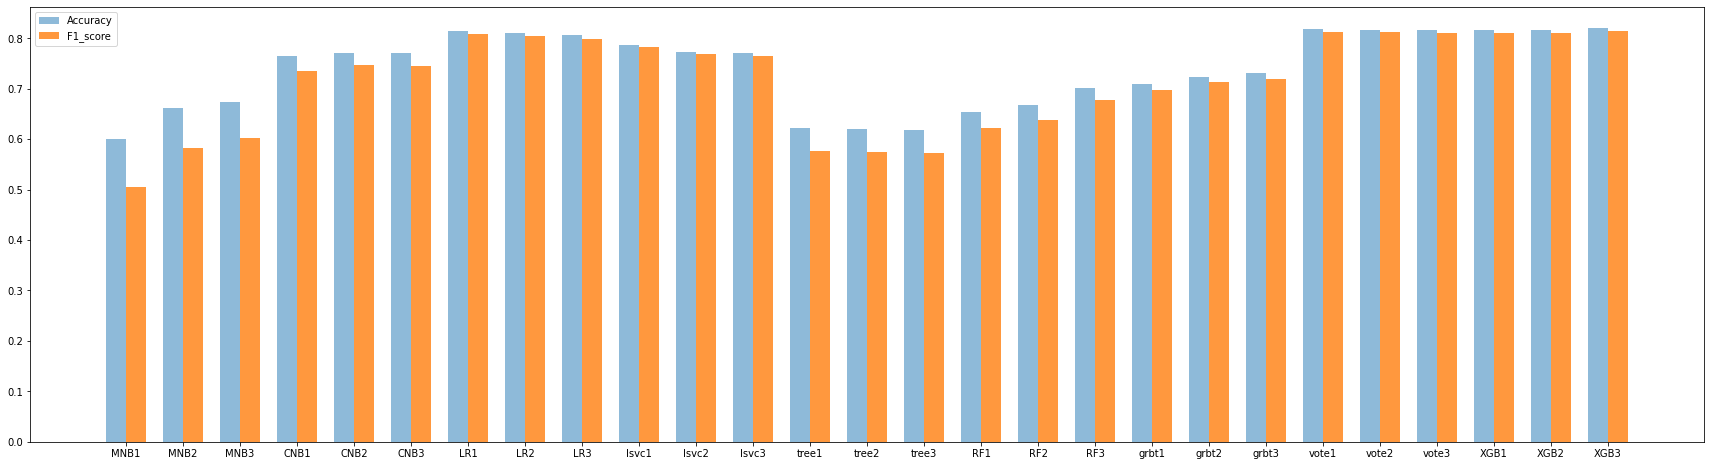

In [206]:
#모델 스코어 시각화
x = np.arange(len(plot_data))
width=0.35
fig,axes=plt.subplots(figsize=(30,8))
axes.bar(x-width/2,plot_data.Accuracy,width,alpha=0.5)
axes.bar(x+width/2,plot_data.F1_score,width,alpha=0.8)
plt.xticks(x)
axes.set_xticklabels(plot_data.model)
plt.legend(['Accuracy','F1_score'])

## 모델학습 딥러닝

### GRU_1

In [123]:
#테스트 score 저장소
model_name = []
loss_list = []
acc_list = []
def listup(name,loss,acc):
  model_name.append(name)
  loss_list.append(loss)
  acc_list.append(acc)
listup('GRU_1',2.407835006713867,0.6487088203430176)

In [119]:
index_to_word[0]

'<pad>'

In [121]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

In [122]:
train_data = keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=500)

test_data = keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=500)

In [ ]:
model = keras.Sequential()
model.add(tf.keras.layers.Embedding(10000, 64))
model.add(layers.GRU(256,return_sequences=True))
model.add(layers.GRU(256,return_sequences=True))
model.add(layers.GRU(256))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, None, 64)          640000    
                                                                 
 gru_18 (GRU)                (None, None, 256)         247296    
                                                                 
 gru_19 (GRU)                (None, None, 256)         394752    
                                                                 
 gru_20 (GRU)                (None, 256)               394752    
                                                                 
 dense_18 (Dense)            (None, 64)                16448     
                                                                 
 dense_19 (Dense)            (None, 46)                2990      
                                                                 
Total params: 1,696,238
Trainable params: 1,696,238
N

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
x_val = train_data[:1800]
partial_x_train = train_data[1800:]

y_val = y_train[:1800]
partial_y_train = y_train[1800:]

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40
113/113 [==============================] - 21s 151ms/step - loss: 2.5545 - accuracy: 0.3332 - val_loss: 2.4046 - val_accuracy: 0.3422
Epoch 2/40
113/113 [==============================] - 16s 143ms/step - loss: 2.0620 - accuracy: 0.3924 - val_loss: 1.8904 - val_accuracy: 0.4544
Epoch 3/40
113/113 [==============================] - 16s 144ms/step - loss: 1.9634 - accuracy: 0.4657 - val_loss: 1.9220 - val_accuracy: 0.4589
Epoch 4/40
113/113 [==============================] - 16s 144ms/step - loss: 1.6953 - accuracy: 0.5468 - val_loss: 1.7264 - val_accuracy: 0.5333
Epoch 5/40
113/113 [==============================] - 16s 143ms/step - loss: 1.5966 - accuracy: 0.5795 - val_loss: 1.6831 - val_accuracy: 0.5883
Epoch 6/40
113/113 [==============================] - 16s 143ms/step - loss: 1.6802 - accuracy: 0.5508 - val_loss: 1.7499 - val_accuracy: 0.5328
Epoch 7/40
113/113 [==============================] - 16s 144ms/step - loss: 1.4968 - accuracy: 0.5941 - val_loss: 1.6057 - val_ac

In [ ]:
results = model.evaluate(test_data,  y_test, verbose=2)
listup('GRU_1',results[0],results[1])
print(results)

71/71 - 3s - loss: 2.4078 - accuracy: 0.6487 - 3s/epoch - 38ms/step
[2.407835006713867, 0.6487088203430176]


In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

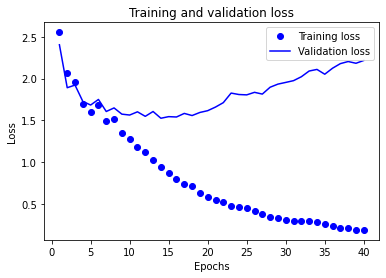

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### GRU_2

In [124]:
model = keras.Sequential()
model.add(tf.keras.layers.Embedding(10000, 64))
model.add(layers.GRU(256,return_sequences=True))
model.add(layers.GRU(256,return_sequences=True))
model.add(layers.GRU(256,return_sequences=True))
model.add(layers.GRU(256))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          640000    
                                                                 
 gru_4 (GRU)                 (None, None, 256)         247296    
                                                                 
 gru_5 (GRU)                 (None, None, 256)         394752    
                                                                 
 gru_6 (GRU)                 (None, None, 256)         394752    
                                                                 
 gru_7 (GRU)                 (None, 256)               394752    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 46)               

In [125]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
check = ModelCheckpoint('best_model_lstm.h5', monitor='val_acc', mode='max', verbose=1, save_bast_only=True)

In [126]:
x_val = train_data[:1800]
partial_x_train = train_data[1800:]

y_val = y_train[:1800]
partial_y_train = y_train[1800:]

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    callbacks=[early,check],
                    verbose=1)

Epoch 1/40
113/113 [==============================] - ETA: 0s - loss: 2.5077 - accuracy: 0.3441
Epoch 1: saving model to best_model_lstm.h5
113/113 [==============================] - 36s 216ms/step - loss: 2.5077 - accuracy: 0.3441 - val_loss: 2.4295 - val_accuracy: 0.3422
Epoch 2/40
113/113 [==============================] - ETA: 0s - loss: 2.1642 - accuracy: 0.4092
Epoch 2: saving model to best_model_lstm.h5
113/113 [==============================] - 23s 203ms/step - loss: 2.1642 - accuracy: 0.4092 - val_loss: 2.0142 - val_accuracy: 0.4883
Epoch 3/40
113/113 [==============================] - ETA: 0s - loss: 1.7250 - accuracy: 0.5384
Epoch 3: saving model to best_model_lstm.h5
113/113 [==============================] - 23s 203ms/step - loss: 1.7250 - accuracy: 0.5384 - val_loss: 1.7224 - val_accuracy: 0.5717
Epoch 4/40
113/113 [==============================] - ETA: 0s - loss: 1.5166 - accuracy: 0.6094
Epoch 4: saving model to best_model_lstm.h5
113/113 [=============================

In [127]:
results = model.evaluate(test_data,  y_test, verbose=2)
listup('GRU_2',results[0],results[1])
print(results)

71/71 - 4s - loss: 1.5003 - accuracy: 0.6696 - 4s/epoch - 55ms/step
[1.5003076791763306, 0.6696348786354065]


In [128]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

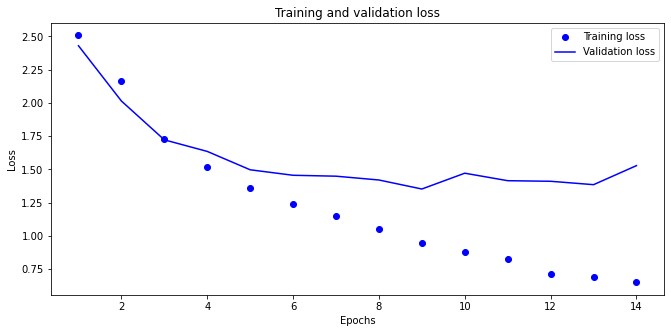

In [129]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

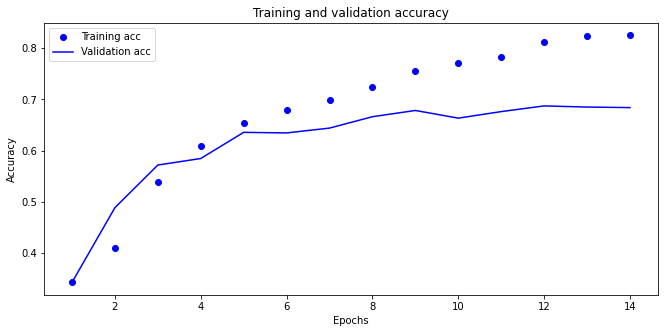

In [130]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### GRU_3

In [ ]:
model = keras.Sequential()
model.add(tf.keras.layers.Embedding(10000, 64))
model.add(layers.GRU(256,return_sequences=True))
model.add(layers.GRU(256,return_sequences=True))
model.add(layers.GRU(256,dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
model.add(layers.GRU(256))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          640000    
                                                                 
 gru_8 (GRU)                 (None, None, 256)         247296    
                                                                 
 gru_9 (GRU)                 (None, None, 256)         394752    
                                                                 
 gru_10 (GRU)                (None, None, 256)         394752    
                                                                 
 gru_11 (GRU)                (None, 256)               394752    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 46)               

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
check = ModelCheckpoint('best_model_lstm.h5', monitor='val_acc', mode='max', verbose=1, save_bast_only=True)

In [ ]:
x_val = train_data[:1800]
partial_x_train = train_data[1800:]

y_val = y_train[:1800]
partial_y_train = y_train[1800:]

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    callbacks=[early,check],
                    verbose=1)

Epoch 1/40
113/113 [==============================] - ETA: 0s - loss: 2.5089 - accuracy: 0.3357
Epoch 1: saving model to best_model_lstm.h5
113/113 [==============================] - 204s 2s/step - loss: 2.5089 - accuracy: 0.3357 - val_loss: 2.4315 - val_accuracy: 0.3422
Epoch 2/40
113/113 [==============================] - ETA: 0s - loss: 2.3670 - accuracy: 0.3569
Epoch 2: saving model to best_model_lstm.h5
113/113 [==============================] - 196s 2s/step - loss: 2.3670 - accuracy: 0.3569 - val_loss: 2.0755 - val_accuracy: 0.3550
Epoch 3/40
113/113 [==============================] - ETA: 0s - loss: 1.8090 - accuracy: 0.4985
Epoch 3: saving model to best_model_lstm.h5
113/113 [==============================] - 197s 2s/step - loss: 1.8090 - accuracy: 0.4985 - val_loss: 1.7508 - val_accuracy: 0.5439
Epoch 4/40
113/113 [==============================] - ETA: 0s - loss: 1.5247 - accuracy: 0.6119
Epoch 4: saving model to best_model_lstm.h5
113/113 [==============================] - 1

In [ ]:
results = model.evaluate(test_data,  y_test, verbose=2)
listup('GRU_3',results[0],results[1])
print(results)

71/71 - 11s - loss: 1.3956 - accuracy: 0.6995 - 11s/epoch - 152ms/step
[1.3955602645874023, 0.6994656920433044]


In [ ]:
# listup('GRU_1',2.407835006713867,0.6487088203430176)
# listup('GRU_2',results[0],results[1])

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

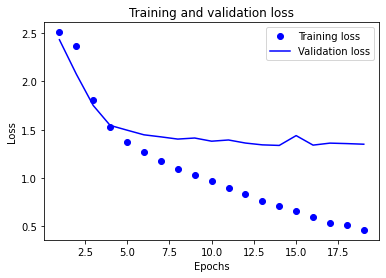

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

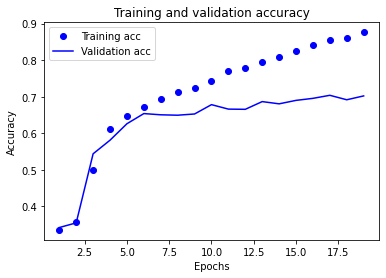

In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [135]:
model_name.append('GRU_3')
loss_list.append(1.3955602645874023)
acc_list.append(0.6994656920433044)

In [140]:
model_data = pd.DataFrame({'model':model_name,'test_loss':loss_list,'test_acc':acc_list})
model_data

,model,test_loss,test_acc
0,GRU_1,2.407835,0.648709
1,GRU_2,1.500308,0.669635
2,GRU_3,1.395560,0.699466


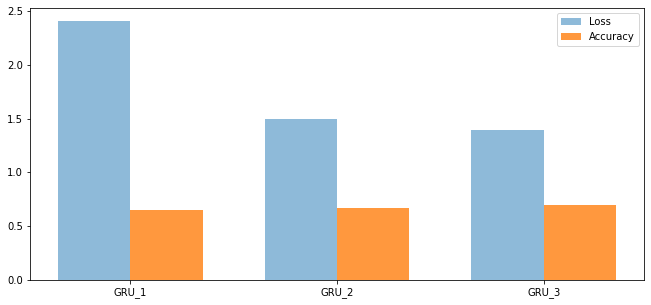

In [151]:
#GRU 실험결과 TEST SET 기준
x = np.arange(len(model_data))
width=0.35
fig,axes=plt.subplots()
axes.bar(x-width/2,model_data.test_loss,width,alpha=0.5)
axes.bar(x+width/2,model_data.test_acc,width,alpha=0.8)
plt.xticks(x)
axes.set_xticklabels(model_data.model)
plt.legend(['Loss','Accuracy'])

## 회고록
num_word는 전체, 8000 , 5000 의 세가지로 실험하였는데, 전체단어셋에서 낮게 성능이 나온 모델들에서는 유의미하게 향상된 부분이있지만, 이미 80%에 근접한 모델들의 경우 크게 차이는 없었다. 일부모델에서는 오히려 하락하는 모습도 보여 각 모델별로 다양한 실험이 필요해보였다.  

머신러닝 vs 딥러닝의 결과 머신러닝의 일부모델들(특히 트리계열)을 제외하고 머신러닝 모델들이 80% 상회하는 정확도와 F1을 보여주었다.  
GRU의 경우 훈련속도에 비해서 다소 아쉬운 성능을 보여주었는데,Dropout을 쓴것과 안쓴것의 차이가 의외로 컸다. 다만 무분별한 Dropout 쌓기는 훈련속도에 큰 영향을 줄수있으니 적정선을 찾는 것이 필요해보였다.